# Video Classification Model with MovieNet (Transfer Learning)

In [1]:
# install
!pip install tensorflow tensorflow-hub opencv-python matplotlib

In [2]:
# imports
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
# constants
NUM_FRAMES = 32
TARGET_HEIGHT = 224
TARGET_WIDTH = 224

In [4]:
# MoViNet model from TF Hub
model_url = "https://tfhub.dev/tensorflow/movinet/a2/base/kinetics-600/classification/3"
movinet_model = hub.load(model_url)
model_fn = movinet_model.signatures['serving_default']

In [5]:
# Kinetics-600 label subset
kinetics_labels = [
    'abseiling', 'air drumming', 'answering questions', 'applauding',
    'applying cream', 'archery', 'arm wrestling', 'arranging flowers',
    'assembling computer', 'auctioning', 'baby waking up', 'baking cookies',
    'balloon blowing', 'bandaging', 'barbequing', 'bartending',
    'beatboxing', 'bee keeping', 'belly dancing', 'bench pressing'
]

In [6]:
def generate_video(num_frames=32, height=224, width=224):
    video = np.zeros((num_frames, height, width, 3), dtype=np.uint8)

    for i in range(num_frames):
        frame = np.full((height, width, 3), fill_value=30, dtype=np.uint8)

        for y in range(0, height, 50):
            cv2.line(frame, (0, y), (width, y), (70, 70, 70), 1)
        for x in range(0, width, 50):
            cv2.line(frame, (x, 0), (x, height), (70, 70, 70), 1)

        start_x = 20 + (i * 5) % (width - 60)
        start_y = 60 + (i * 3) % (height - 60)
        end_x = start_x + 40
        end_y = start_y + 40
        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), -1)

        cv2.putText(frame, f"Frame {i+1}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

        video[i] = frame

    return video

In [7]:
# preprocess video for model input
def preprocess(video):
    video = video.astype(np.float32) / 255.0
    video = tf.convert_to_tensor(video)
    video = tf.image.resize(video, [TARGET_HEIGHT, TARGET_WIDTH])
    video = tf.expand_dims(video, axis=0)

    return video

In [8]:
# predict class using MoViNet
def predict(video_tensor):
    output = model_fn(video_tensor)
    logits = list(output.values())[0]
    probs = tf.nn.softmax(logits)
    class_index = tf.argmax(probs, axis=-1).numpy()[0]
    confidence = tf.reduce_max(probs).numpy()

    return class_index, confidence

In [9]:
# visualize video frames
def visualize_video_frames(video_array, num_frames=6):
    plt.figure(figsize=(15, 4))
    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(cv2.cvtColor(video_array[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
# run pipeline
video = generate_video()

In [11]:
video_tensor = preprocess(video)
pred_class, confidence = predict(video_tensor)

In [12]:
# output prediction
print(f"Predicted Class: {kinetics_labels[pred_class] if pred_class < len(kinetics_labels) else 'Unknown'}")
print(f"Confidence: {confidence:.2%}")

Predicted Class: Unknown
Confidence: 4.05%


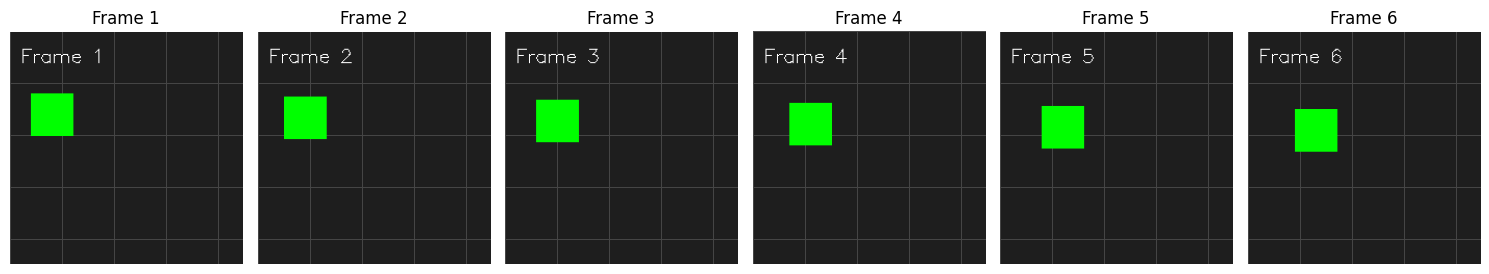

In [13]:
# visualize the frames
visualize_video_frames(video)